In [5]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

In [6]:
image_size= 200
Batch_size=32
epochs=50
data_folder ='dataset'
channels=3

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_folder,
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=Batch_size
)

Found 3064 files belonging to 3 classes.


In [8]:
class_names=dataset.class_names
class_names

['glioma', 'meningioma', 'pituitary']

In [9]:
def train_test_validate(ds,train=0.8,test=0.1,validate=0.1,shuffle=True,shuffle_size=1000):
    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size =int(ds_size*train)
    val_size = int(ds_size*validate)
    
    train_set =ds.take(train_size)
    val_set =ds.skip(train_size).take(val_size)
    test_set =ds.skip(train_size).skip(val_size)
    
    return train_set,test_set,val_set
    
    

In [10]:
train_ds,test_ds,val_ds = train_test_validate(dataset)

In [11]:
len(train_ds)

76

In [12]:
train_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds =test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [13]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape= (Batch_size,image_size,image_size, channels)
n_classes=3
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 200, 200, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 200, 200, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 198, 198, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 99, 99, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 97, 97, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 48, 48, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 46, 46, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
with tf.device('/CPU:0'):
    history= model.fit(
            train_ds,
            epochs=epochs,
            batch_size=Batch_size,
            verbose=1,
            validation_data=val_ds
        )

Epoch 1/50
76/76 [==============================] - 59s 724ms/step - loss: 1.0130 - accuracy: 0.4988 - val_loss: 0.7848 - val_accuracy: 0.6597
Epoch 2/50
76/76 [==============================] - 51s 675ms/step - loss: 0.8373 - accuracy: 0.6258 - val_loss: 0.8120 - val_accuracy: 0.6389
Epoch 3/50
76/76 [==============================] - 55s 720ms/step - loss: 0.7775 - accuracy: 0.6514 - val_loss: 0.7346 - val_accuracy: 0.6840
Epoch 4/50
76/76 [==============================] - 57s 748ms/step - loss: 0.7292 - accuracy: 0.6848 - val_loss: 0.6581 - val_accuracy: 0.7257
Epoch 5/50
76/76 [==============================] - 59s 781ms/step - loss: 0.6440 - accuracy: 0.7244 - val_loss: 0.5823 - val_accuracy: 0.7535
Epoch 6/50
76/76 [==============================] - 57s 756ms/step - loss: 0.6309 - accuracy: 0.7277 - val_loss: 0.5695 - val_accuracy: 0.7535
Epoch 7/50
76/76 [==============================] - 54s 713ms/step - loss: 0.5999 - accuracy: 0.7430 - val_loss: 0.6402 - val_accuracy: 0.7396

In [19]:
with tf.device('/CPU:0'):
    test_score = model.evaluate(test_ds)
    test_score


11/11 [==============================] - 30s 187ms/step - loss: 0.2769 - accuracy: 0.9119


In [20]:
model_version=1
with tf.device('/CPU:0'):
    model.save(f"./model/{model_version}")

INFO:tensorflow:Assets written to: ./model/1\assets


In [22]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 76}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc =history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training & Validation loss')

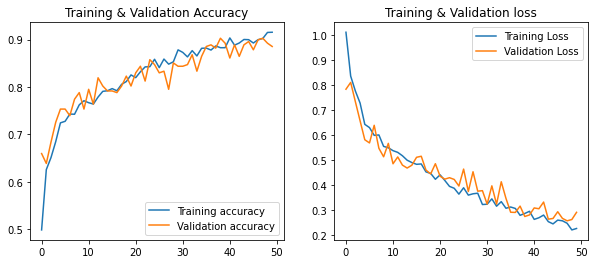

In [30]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc,label='Training accuracy')
plt.plot(range(epochs),val_acc,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs),loss,label='Training Loss')
plt.plot(range(epochs),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation loss')